<a href="https://colab.research.google.com/github/KevinQuinonesA/autoencoder-gan/blob/add-checkpoints/autoencoder-gan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch

In [ ]:
from __future__ import print_function
#%matplotlib inline
import argparse
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

# Set random seed for reproducibility
manualSeed = 999 # 42
#manualSeed = random.randint(1, 10000) # use if you want new results
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)

Random Seed:  999


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Root directory for dataset

train_dataroot = "/content/drive/MyDrive/UNIVERSIDAD 5TO/COSAS MIAS/GANS/DATASET/Originales2/output/train"
test_dataroot  = "/content/drive/MyDrive/UNIVERSIDAD 5TO/COSAS MIAS/GANS/DATASET/Originales2/output/test"
val_dataroot = "/content/drive/MyDrive/UNIVERSIDAD 5TO/COSAS MIAS/GANS/DATASET/Originales2/output/val"
checkpoints_folder = "/content/drive/MyDrive/UNIVERSIDAD 5TO/COSAS MIAS/GANS/DATASET/Originales2/output/checkpoints"

#train_dataroot = "/content/drive/MyDrive/9 Semestre/Seminario de Tesisi/output/train"
#test_dataroot = "/content/drive/MyDrive/9 Semestre/Seminario de Tesisi/output/test"
#val_dataroot = "/content/drive/MyDrive/9 Semestre/Seminario de Tesisi/output/val"
#checkpoints_folder = "/content/drive/MyDrive/9 Semestre/Seminario de Tesisi/output/checkpoints"



# Number of workers for dataloader
workers    = 2      # 4 # 8

# Batch size during training
batch_size = 32     # 8 (en caso que las imágenes sean muy pesadas or ERROR: CUDA OUT OF MEMORY)

# Spatial size of training images. All images will be resized to this
#   size using a transformer.
image_size = 128

# Number of channels in the training images. 
nc = 1

# Size of z latent vector (i.e. size of generator input)
nz = 16   # 100 # 256

# Size of feature maps in generator
ngf = 64

# Size of feature maps in discriminator
ndf = 64

# Number of training epochs 
num_epochs = 30 # 300

# Learning rate for optimizers ------ Optimizar
lr = 0.0002

# Beta1 hyperparam for Adam optimizers
beta1 = 0.5 #(0.9, 0.999)

# Number of GPUs available. Use 0 for CPU mode.
ngpu = 1
#test

Dataset ImageFolder
    Number of datapoints: 1831
    Root location: /content/drive/MyDrive/9 Semestre/Seminario de Tesisi/output/train
    StandardTransform
Transform: Compose(
               Resize(size=128, interpolation=bilinear, max_size=None, antialias=warn)
               Grayscale(num_output_channels=1)
               CenterCrop(size=(128, 128))
               ToTensor()
               Normalize(mean=[0.5], std=[0.5])
           )

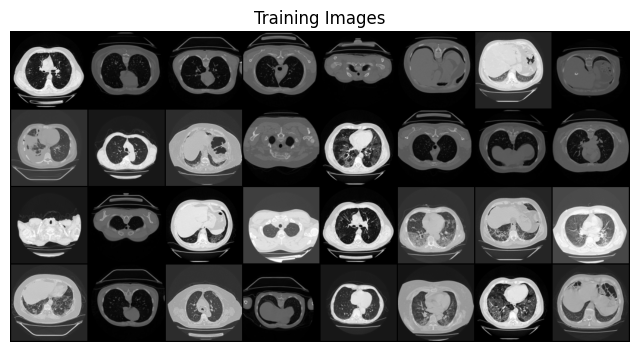

In [ ]:
## We can use an image folder dataset the way we have it setup.
# Create the dataset

train_dataset = dset.ImageFolder(root=train_dataroot,
                           transform=transforms.Compose([
                               transforms.Resize(image_size),
                               transforms.Grayscale(num_output_channels=1),
                               transforms.CenterCrop(image_size),
                               transforms.ToTensor(),
                               transforms.Normalize([0.5], [0.5]),
                           ]))

test_dataset = dset.ImageFolder(root=test_dataroot,
                           transform=transforms.Compose([
                               transforms.Resize(image_size),
                               transforms.Grayscale(num_output_channels=1),
                               transforms.CenterCrop(image_size),
                               transforms.ToTensor(),
                               transforms.Normalize([0.5], [0.5]),
                           ]))

val_dataset = dset.ImageFolder(root=val_dataroot,
                           transform=transforms.Compose([
                               transforms.Resize(image_size),
                               transforms.Grayscale(num_output_channels=1),
                               transforms.CenterCrop(image_size),
                               transforms.ToTensor(),
                               transforms.Normalize([0.5], [0.5]),
                           ]))

# Create the dataloader
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size,
                                         shuffle=True, num_workers=workers)

valid_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size,
                                         shuffle=True, num_workers=workers)

test_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size,
                                         shuffle=True, num_workers=workers)


# Decide which device we want to run on
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

# Plot some training images
real_batch = next(iter(train_loader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))
train_dataset

In [ ]:
# custom weights initialization called on netG and netD
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1: #Conv2d
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1: # BatchNorm2d
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [ ]:
class Autoencoder(torch.nn.Module):
    def __init__(self):
        super().__init__()
         
        # Building an linear encoder with Linear
        # layer followed by Relu activation function
        # 784 ==> 9
        self.encoder = torch.nn.Sequential(
            nn.Conv2d(1, 16 , 3, stride=2, padding =1), #N, 2, 64, 64
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.Conv2d(16, 32 , 3, stride=2, padding =1), #N, 4, 32, 32
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 64 , 3, stride=2, padding =1), #N, 8, 16, 16
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 128 , 3, stride=2, padding =1), #N, 16, 8, 8
           
        )
         
        # Building an linear decoder with Linear
        # layer followed by Relu activation function
        # The Sigmoid activation function
        # outputs the value between 0 and 1
        # 9 ==> 784
        self.decoder = torch.nn.Sequential(
            
          
            nn.ConvTranspose2d(128, 64, 3, stride=2, padding=1, output_padding=1), # N, 8, 16, 16
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, 3, stride=2, padding=1, output_padding=1),  # N, 4, 32, 32
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, 3, stride=2, padding=1, output_padding=1), # N, 2, 64, 64
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 1, 3, stride=2, padding=1, output_padding=1),  # N, 1, 128, 128
        )
 
    def forward(self, x):
        latent = self.encoder(x)
        image_re = self.decoder(latent)
        return image_re


In [ ]:
class Discriminator(nn.Module):
    def __init__(self, ngpu):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is (nc) x 128 x 128
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 64 x 64
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 32 x 32
            nn.Conv2d(ndf*2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 16 x 16
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 8 x 8
            nn.Conv2d(ndf * 8, ndf * 16, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 16),
            nn.LeakyReLU(0.2, inplace=True)
          )          
            # state size. (ndf*8) x 4 x 4
        self.last_layer = nn.Sequential(
            nn.Conv2d(ndf * 16, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
            
        )

    def forward(self, input):
        x = self.main(input)
        out = self.last_layer(x)
        return x, out

In [ ]:
# Create the Discriminator
netD = Discriminator(ngpu).to(device)

# Handle multi-gpu if desired
if (device.type == 'cuda') and (ngpu > 1):
    netD = nn.DataParallel(netD, list(range(ngpu)))

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.2.
netD.apply(weights_init)

# Print the model
print(netD)

# Create the generator/AUTOENCODER
netG = Autoencoder().to(device)

# Handle multi-gpu if desired
if (device.type == 'cuda') and (ngpu > 1):
    netG = nn.DataParallel(netG, list(range(ngpu)))

# Print the model
print(netG)

Discriminator(
  (main): Sequential(
    (0): Conv2d(1, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1024, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (12): BatchNorm2d(1024, eps=1e-05

In [ ]:
# Initialize BCELoss function
criterion = nn.BCELoss()
loss_function = torch.nn.MSELoss()
loss_function_penalty  = torch.nn.MSELoss()
# Create batch of latent vectors that we will use to visualize
#  the progression of the generator
fixed_noise = torch.randn(64, nz, 1, 1, device=device)

# Establish convention for real and fake labels during training
real_label = 1.
fake_label = 0.

# Setup Adam optimizers for both G and D
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))

# Using an Adam Optimizer with lr = 0.1
optimizerG = torch.optim.Adam(netG.parameters(),
                             lr = 1e-1,
                             weight_decay = 1e-8)

In [ ]:
# Training Loop

# Lists to keep track of progress
img_list = []
G_losses = []
D_losses = []

img_list_val = []
G_losses_val = []
D_losses_val = []

iters = 0

print("Starting Training Loop...")
# For each epoch
for epoch in range(num_epochs):

    loss_total_disc = 0
    # For each batch in the dataloader
    netD.train()
    netG.train()
    for i, data in enumerate(train_loader, 0):

        
        real_cpu = data[0].to(device)
        # Generate fake image batch with G
        netG.zero_grad()
        fake = netG(real_cpu)
        output_fake_g, f2 = netD(fake)
        output_real_g, f1 = netD(real_cpu)
        
       
        loss_g = loss_function(fake, real_cpu) + loss_function_penalty(output_fake_g, output_real_g)
        
        # Classify all fake batch with D
        loss_g.backward()
        optimizerG.step()
       

 
        #DISCRIMINADOR
        netD.zero_grad()
        x1,output_fake = netD(fake.detach())
        x2,output_real = netD(real_cpu.detach())

        #LABELS
        b_size = real_cpu.size(0)
        label_real = torch.full((b_size,), real_label, dtype=torch.float, device=device)
        label_fake = torch.full((b_size,), fake_label, dtype=torch.float, device=device)
        # Calculate D's loss on the all-fake batch
        loss_fake = criterion(output_fake.view(-1), label_fake)
        loss_real = criterion(output_real.view(-1), label_real)
        loss_dic_tr = (loss_fake + loss_real)*0.5
        loss_total_disc += loss_dic_tr.item()

        loss_dic_tr.backward()
        optimizerD.step()
        #label.fill_(fake_label)
        
        D_x = output_real.mean().item()
        D_G_z1 = output_fake.mean().item()

        # Reinit the affine network weights
        if loss_dic_tr.item() < 1e-5:  # >
           netD.apply(weights_init)
           print("Reloading discriminator weights")

        # Output training stats
        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, num_epochs, i, len(train_loader),
                     loss_dic_tr.item(), loss_g.item(), D_x, D_G_z1, D_G_z1))

        # Save Losses for plotting later
        G_losses.append(loss_g.item())
        D_losses.append(loss_dic_tr.item())

        # Check how the generator is doing by saving G's output on fixed_noise
        if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(train_loader)-1)):
            with torch.no_grad():
                fake = netG(real_cpu).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

        iters += 1
    
    with torch.no_grad():
      netG.eval()
      netD.eval()
      loss_total_disc = 0

      # For each batch in the dataloader
      for i, data in enumerate(valid_loader, 0):
          
          real_cpu = data[0].to(device)
          # Generate fake image batch with G
          fake = netG(real_cpu)
          output_fake_g, f2 = netD(fake)
          output_real_g, f1 = netD(real_cpu)
          
        
          loss_g = loss_function(fake, real_cpu) + loss_function_penalty(output_fake_g, output_real_g)
          
          # Classify all fake batch with D

  
          #DISCRIMINADOR
          x1,output_fake = netD(fake.detach())
          x2,output_real = netD(real_cpu.detach())

          #LABELS
          b_size = real_cpu.size(0)
          label_real = torch.full((b_size,), real_label, dtype=torch.float, device=device)
          label_fake = torch.full((b_size,), fake_label, dtype=torch.float, device=device)
          # Calculate D's loss on the all-fake batch
          loss_fake = criterion(output_fake.view(-1), label_fake)
          loss_real = criterion(output_real.view(-1), label_real)
          loss_dic_tr = (loss_fake + loss_real)*0.5
          loss_total_disc += loss_dic_tr.item()

          #label.fill_(fake_label)
          
          D_x = output_real.mean().item()
          D_G_z1 = output_fake.mean().item()


          # Output training stats
          if i % 50 == 0:
              print('[%d/%d][%d/%d]\t Validation Loss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                    % (epoch, num_epochs, i, len(valid_loader),
                      loss_dic_tr.item(), loss_g.item(), D_x, D_G_z1, D_G_z1))

          # Save Losses for plotting later
          G_losses_val.append(loss_g.item())
          D_losses_val.append(loss_dic_tr.item())

          # Check how the generator is doing by saving G's output on fixed_noise
          if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(valid_loader)-1)):
              with torch.no_grad():
                  fake = netG(real_cpu).detach().cpu()
              img_list_val.append(vutils.make_grid(fake, padding=2, normalize=True))

          iters += 1

    # Save checkpoints
    if epoch % 10 == 0:
        name_gen = 'GenModel_' + str(epoch) + '.pth'
        name_dis = 'DisModel_' + str(epoch) + '.pth'
        torch.save(netG.state_dict(), os.path.join(checkpoints_folder, name_gen))
        torch.save(netD.state_dict(), os.path.join(checkpoints_folder, name_dis))
        print('Saving model')

Starting Training Loop...
[0/30][0/58]	Loss_D: 1.3981	Loss_G: 2.3450	D(x): 0.6667	D(G(z)): 0.7881 / 0.7881
[0/30][50/58]	Loss_D: 3.0554	Loss_G: 0.6367	D(x): 1.0000	D(G(z)): 0.7455 / 0.7455
[0/30][0/17]	 Validation Loss_D: 0.6213	Loss_G: 0.7808	D(x): 0.7696	D(G(z)): 0.0000 / 0.0000
Saving model
[1/30][0/58]	Loss_D: 0.0561	Loss_G: 0.4962	D(x): 0.9326	D(G(z)): 0.0000 / 0.0000
Reloading discriminator weights
[1/30][50/58]	Loss_D: 0.0441	Loss_G: 0.4546	D(x): 0.9495	D(G(z)): 0.0025 / 0.0025
[1/30][0/17]	 Validation Loss_D: 0.0538	Loss_G: 0.5895	D(x): 0.9608	D(G(z)): 0.0345 / 0.0345
[2/30][0/58]	Loss_D: 0.0079	Loss_G: 0.4333	D(x): 0.9973	D(G(z)): 0.0108 / 0.0108
[2/30][50/58]	Loss_D: 0.0018	Loss_G: 0.4145	D(x): 0.9999	D(G(z)): 0.0034 / 0.0034
Reloading discriminator weights
[2/30][0/17]	 Validation Loss_D: 1.5626	Loss_G: 0.5554	D(x): 0.6809	D(G(z)): 0.8126 / 0.8126
[3/30][0/58]	Loss_D: 0.7929	Loss_G: 0.3871	D(x): 0.6026	D(G(z)): 0.5342 / 0.5342
[3/30][50/58]	Loss_D: 0.0042	Loss_G: 0.1919	D(x)

In [ ]:
print(f'NUMERO DE FAKES{img_list}')

NUMERO DE FAKES[tensor([[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.8169,  ..., 0.8030, 0.0000, 0.0000],
         ...,
         [0.0000, 0.0000, 0.8042,  ..., 0.8150, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

        [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.8169,  ..., 0.8030, 0.0000, 0.0000],
         ...,
         [0.0000, 0.0000, 0.8042,  ..., 0.8150, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

        [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.8169,  ..., 0.

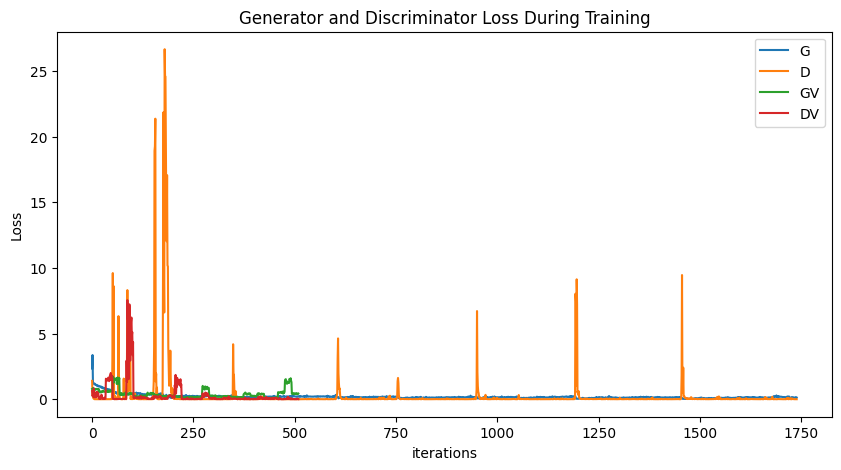

In [ ]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.plot(G_losses_val,label="GV")
plt.plot(D_losses_val,label="DV")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

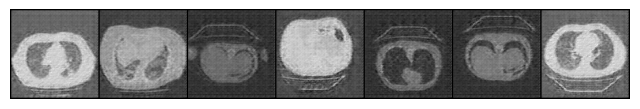

In [ ]:
#%%capture
fig = plt.figure(figsize=(8,8))
plt.axis("off")
ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in img_list]
ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)

HTML(ani.to_jshtml())

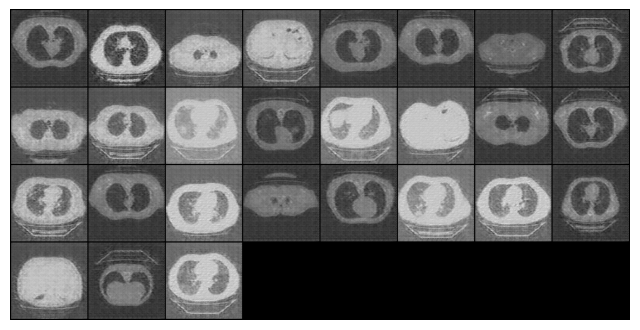

In [ ]:
#Validation
#%%capture
fig = plt.figure(figsize=(8,8))
plt.axis("off")
ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in img_list_val]
ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)

HTML(ani.to_jshtml())

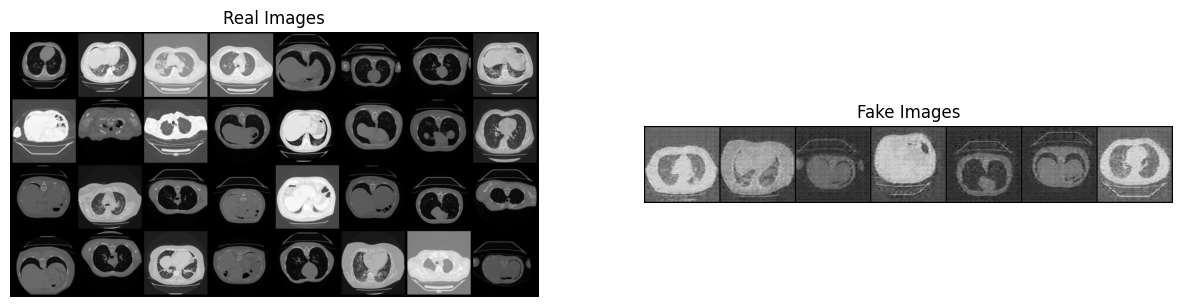

In [ ]:
# Grab a batch of real images from the dataloader
real_batch = next(iter(train_loader))

# Plot the real images
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))

# Plot the fake images from the last epoch
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(img_list[-1],(1,2,0)))
plt.show()

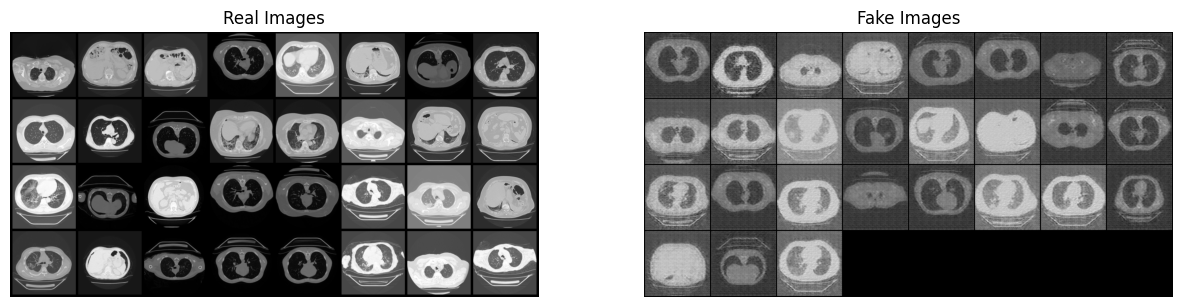

In [ ]:
# Grab a batch of real images from the dataloader
real_batch = next(iter(valid_loader))

# Plot the real images
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))

# Plot the fake images from the last epoch
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(img_list_val[-1],(1,2,0)))
plt.show()

In [ ]:
# from skimage import io


# image=io.imread("/content/drive/MyDrive/UNIVERSIDAD 5TO/COSAS MIAS/GANS/DATASET/images/test.png")/255.0 # imread lee las imagenes con los pixeles codificados como enteros 
# # en el rango 0-255. Por eso la convertimos a flotante y en el rango 0-1

# print("- Dimensiones de la imagen:")
# print(image.shape)

# plt.imshow(image,vmin=0,vmax=1)

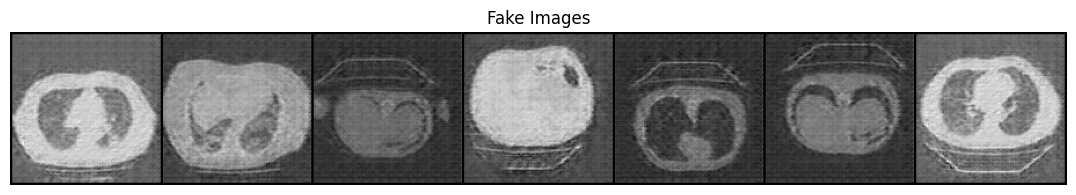

torch.Size([132, 912, 3])


In [ ]:
# Grab a batch of real images from the dataloader
real_batch = next(iter(train_loader))

# Plot the fake images from the last epoch
plt.figure(figsize=(30,30))
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(img_list[-1],(1,2,0)))
plt.show()
print(np.transpose(img_list[-1],(1,2,0)).size())

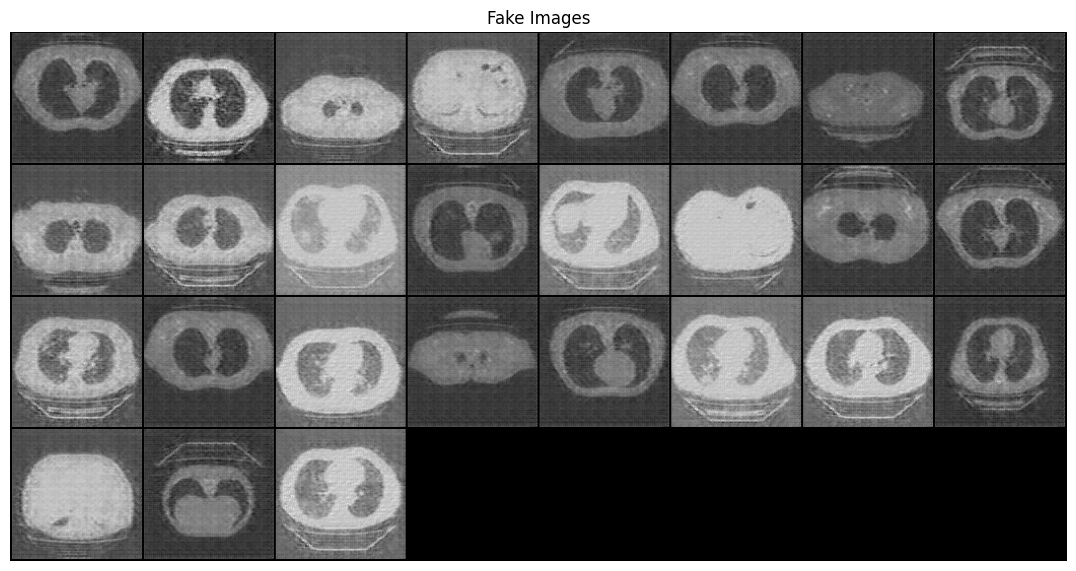

torch.Size([522, 1042, 3])


In [ ]:
# Grab a batch of real images from the dataloader
real_batch = next(iter(valid_loader))

# Plot the fake images from the last epoch
plt.figure(figsize=(30,30))
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(img_list_val[-1],(1,2,0)))
plt.show()
print(np.transpose(img_list_val[-1],(1,2,0)).size())

In [ ]:
checkpoint = torch.load(checkpoint_folder)

# Cargar los parámetros de la red neuronal

netG.load_state_dict(torch.load(os.path.join(checkpoints_folder, name_gen)))
netD.load_state_dict(torch.load(os.path.join(checkpoints_folder, name_dis)))

# Evaluar el modelo en el conjunto de datos de prueba
netG.eval()
netD.eval()

correctos = 0
total = 0
with torch.no_grad():
    
      loss_total_disc = 0

      # For each batch in the dataloader
      for i, data in enumerate(test_loader, 0):
          
          real_cpu = data[0].to(device)
          # Generate fake image batch with G
          fake = netG(real_cpu)
          output_fake_g, f2 = netD(fake)
          output_real_g, f1 = netD(real_cpu)
          imagenes, etiquetas = data  
            
          # Calcular predicciones
          predicciones = torch.round(fake).squeeze()
            
          # Contar aciertos
          correctos += (predicciones == etiquetas).sum().item()
          total += len(etiquetas)
        
          loss_g = loss_function(fake, real_cpu) + loss_function_penalty(output_fake_g, output_real_g)
          
          # Classify all fake batch with D

  
          #DISCRIMINADOR
          x1,output_fake = netD(fake.detach())
          x2,output_real = netD(real_cpu.detach())

          #LABELS
          b_size = real_cpu.size(0)
          label_real = torch.full((b_size,), real_label, dtype=torch.float, device=device)
          label_fake = torch.full((b_size,), fake_label, dtype=torch.float, device=device)
          # Calculate D's loss on the all-fake batch
          loss_fake = criterion(output_fake.view(-1), label_fake)
          loss_real = criterion(output_real.view(-1), label_real)
          loss_dic_tr = (loss_fake + loss_real)*0.5
          loss_total_disc += loss_dic_tr.item()

          #label.fill_(fake_label)
          
          D_x = output_real.mean().item()
          D_G_z1 = output_fake.mean().item()


          # Output training stats
          if i % 50 == 0:
              print('[%d/%d][%d/%d]\t Validation Loss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                    % (epoch, num_epochs, i, len(test_loader),
                      loss_dic_tr.item(), loss_g.item(), D_x, D_G_z1, D_G_z1))

          # Save Losses for plotting later
          G_losses_val.append(loss_g.item())
          D_losses_val.append(loss_dic_tr.item())

          # Check how the generator is doing by saving G's output on fixed_noise
          if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(test_loader)-1)):
              with torch.no_grad():
                  fake = netG(real_cpu).detach().cpu()
              img_list_val.append(vutils.make_grid(fake, padding=2, normalize=True))

          iters += 1
          
    
# Calcular precisión
precision = correctos / total
print("Precisión del generador: {:.4f}".format(precision))



